In [22]:
import matplotlib
matplotlib.use('Qt5Agg')
from header import *
import psutil
from mne.stats import spatio_temporal_cluster_1samp_test, spatio_temporal_cluster_test, permutation_cluster_1samp_test, permutation_cluster_test
from scipy.stats.distributions import f,t
from tqdm import tqdm
import visbrain
from visbrain.objects import BrainObj, ColorbarObj, SceneObj, SourceObj
import xarray as xr
warnings.filterwarnings("ignore",category=DeprecationWarning)

/home/benjamin.ador/.local/lib/python3.5/site-packages/matplotlib/__init__.py:1414: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'TkAgg' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/benjamin.ador/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/benjamin.ador/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/benjamin.ador/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/benjamin.ado

In [2]:
t0 = time.perf_counter()
task = 'SMEG' #'MIMOSA'
states = ['RS','FA','OM']
subjects = get_subjlist(task)
subjects = subjects[:subjects.index('109')]

reject = ['069', '072']
for sub in reject:
    if sub in subjects:
        subjects.remove(sub)

subjects.sort()
#subjects = ['002', '007', '012', '014', '018', '032', '037', '042', '083', '087', '089', '091', '050', '055', '064', '067', '068', '070', '073']
experts = []
novices = []
experts_i = []
novices_i = []
for s,sub in enumerate(subjects):
    if expertise(sub) == 'N':
        novices.append(sub)
        novices_i.append(s)
    if expertise(sub) == 'E':
        experts.append(sub)
        experts_i.append(s)

In [3]:
names = ['R_ECG_included', 'R_ECG_excluded', 'T_ECG_included', 'T_ECG_excluded']
name = names[-1]
noise_cov = 'empty_room_cov'
stc_ext = '-lh.stc'
sfreq = 200
surface = 'ico4'
start = None
stop = None
stc_path = op.join(Analysis_path, task, 'meg', 'SourceEstimate')

In [4]:
data_file = op.join(stc_path, 'fsaverage', 'DATASET-{}-surface_{}-{}Hz.nc'.format(noise_cov, surface, sfreq))
stc = xr.open_dataarray(data_file, name)
stc.load()

<xarray.DataArray (state: 3, subject: 34, time: 30, src: 20484)>
array([[[[0.008415, ..., 0.011181],
         ...,
         [0.034438, ..., 0.016494]],

        ...,

        [[0.098985, ..., 0.038413],
         ...,
         [0.066159, ..., 0.073925]]],


       ...,


       [[[0.039998, ..., 0.029402],
         ...,
         [0.015048, ..., 0.010873]],

        ...,

        [[0.01282 , ..., 0.02239 ],
         ...,
         [0.117287, ..., 0.022826]]]])
Coordinates:
  * src      (src) object 'lh_0' 'lh_1' 'lh_2' 'lh_3' 'lh_4' 'lh_5' 'lh_6' ...
  * state    (state) object 'RS' 'FA' 'OM'
  * subject  (subject) object '002' '004' '007' '010' '012' '014' '016' ...
  * time     (time) float64 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 ...

In [4]:
for st,state in enumerate(states):
    print(state)
    for su,sub in enumerate(tqdm(subjects)):
        stc_file = op.join(stc_path, 'fsaverage', sub, state+'-'+name+'-'+noise_cov+'*'+stc_ext)
        file = glob.glob(stc_file)[0]
        data = mne.read_source_estimate(file[:file.index(stc_ext)])
        if sfreq:
            data.resample(sfreq)
        if not st and not su:#and not n 
            times = data.times
            if not start:
                start = times[0]
            if not stop:
                stop = times[-1]
            vertices = np.concatenate([['lh_' + str(x) for x in data.lh_vertno],['rh_' + str(x) for x in data.rh_vertno]])
            try:
                del stc
            except:
                pass
            stc = np.zeros((len(states), len(subjects), data.data.shape[1], data.data.shape[0]))
            stc = xr.DataArray(stc, dims=['state', 'subject', 'time', 'src'], coords={'state':states, 'subject':subjects, 'time':times, 'src':vertices})
        stc[st,su] = data.data.T
        del data

  0%|          | 0/34 [00:00<?, ?it/s]

RS


  0%|          | 0/34 [00:00<?, ?it/s]

FA


  0%|          | 0/34 [00:00<?, ?it/s]

OM


100%|██████████| 34/34 [02:27<00:00,  4.35s/it]


In [5]:
def cluster_perm_test(X1, X2, stat_file, test_key, times, vertices, mode='a', p_threshold=0.01, connectivity='ico5', paired=False):
    """
    If paired, test X1-X2.
    Input: arrays of shape (subjects, time, space)
    """
    if not isinstance(X2, (np.ndarray, xr.DataArray)):
        X2 = np.zeros(X1.shape)
    
    if type(connectivity) is str:
        connectivity = mne.spatial_tris_connectivity(mne.grade_to_tris(int(connectivity[-1])))
    
    if paired:
        X = X1 - X2
        t_threshold = -t.ppf(p_threshold / 2, X.shape[0] - 1)
        T_obs, clusters, cluster_pv, H0 = spatio_temporal_cluster_1samp_test(X, connectivity=connectivity, threshold=t_threshold, n_jobs=4)
    else:
        f_threshold = f.ppf(1 - p_threshold / 2, X1.shape[0] - 1, X2.shape[0] - 1)
        T_obs, clusters, cluster_pv, H0 = spatio_temporal_cluster_test([X1,X2], connectivity=connectivity, threshold=f_threshold, n_jobs=4)
    
    p_val = np.ones(T_obs.shape)
    clu_inds = np.zeros(T_obs.shape)
    
    for c,clu in enumerate(clusters):
        p_val[clu] = cluster_pv[c]
        clu_inds[clu] = c+1
    
    stats = np.zeros((3, 2, len(times), len(vertices)))
    stats = xr.DataArray(stats, dims=['data', 'hemisphere', 'time', 'src'], coords={'data':['T_stat', 'p_val', 'clu_inds'], 'hemisphere':['left', 'right'], 'time':times, 'src':vertices})
    for h,hemi in enumerate(['left', 'right']):
        i = h + 1
        h *= len(vertices)
        i *= len(vertices)
        stats.loc['T_stat', hemi] = T_obs[:, h:i]
        stats.loc['p_val', hemi] = p_val[:, h:i]
        stats.loc['clu_inds', hemi] = clu_inds[:, h:i]
    
    if not op.isdir(op.split(stat_file)[0]):
        os.makedirs(op.split(stat_file)[0])
    
    if not op.isfile(stat_file):
        mode = 'w'
    
    stats.to_netcdf(path=stat_file, group=test_key, mode=mode)
    #for h,hemi in enumerate(['lh', 'rh']):
    #    i = h + 1
    #    h *= T_obs.shape[1]/2
    #    i *= T_obs.shape[1]/2
    #    
    #    np.savetxt(stat_file+'-'+hemi+'-T_stat.tsv', T_obs[:,int(h):int(i)], delimiter='\t')
    #    np.savetxt(stat_file+'-'+hemi+'-p_val.tsv', mask[:,int(h):int(i)], delimiter='\t')
    #
    return T_obs, clusters, cluster_pv, H0

In [6]:
spacing='ico5'
connectivity = mne.spatial_tris_connectivity(mne.grade_to_tris(int(spacing[-1])))

-- number of connected vertices : 20484


In [7]:
start = stc.time.values[0]
stop = stc.time.values[-1]
vertno = np.arange(stc.shape[-1]/2, dtype=int)

stat_path = op.join(Analysis_path, task, 'meg', 'Stats', '{}_{}'.format(round(start,4),round(stop,4)))
os.makedirs(stat_path, exist_ok=True)
stat_file = op.join(stat_path, '{}-{}-surface_{}-{}Hz.nc'.format(name, noise_cov, surface, sfreq))

In [13]:
T_obs=dict(); clusters=dict(); cluster_pv=dict(); H0=dict(); mask=dict(); clu=dict()

# Heartbeat Evoked Response

In [35]:
test_key = 'HER_0.0001'
#X1 = stc.values.reshape((np.multiply(*stc.shape[0:2]),*stc.shape[2:]))
X1 = stc.values.mean(axis=0)
X2 = np.zeros(X1.shape)
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key], mask[test_key] = cluster_perm_test(X1, X2, stat_file=stat_file, test_key=test_key, times=stc.time.values, vertices=vertno, connectivity=connectivity, paired=True, p_threshold=0.0001)

stat_fun(H1): min=2.469534 max=41.924578
Running initial clustering
Found 6 clusters
Permuting 1023 times...
[...................................     ] 87.84314 \    

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.2min remaining:  1.2min


[....................................... ] 99.22481 |    Computing cluster p-values
Done.


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.3min finished


In [31]:
X1 = stc.values.mean(axis=0)

In [39]:
X1.shape

(34, 30, 20484)

# States tests

In [14]:
t0 = time.perf_counter()
ti = t0
test_key = 'RS_vs_FA'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc.loc['RS',:,start:stop].values, stc.loc['FA',:,start:stop].values, stat_file=stat_file, test_key=test_key, times=stc.time.loc[start:stop], vertices=vertno, connectivity=connectivity, paired=True)
print('\t',test_key, time.perf_counter()-ti,'\n\t*****\n')
ti = time.perf_counter()

test_key = 'RS_vs_OM'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc.loc['RS',:,start:stop].values, stc.loc['OM',:,start:stop].values, stat_file=stat_file, test_key=test_key, times=stc.time.loc[start:stop], vertices=vertno, connectivity=connectivity, paired=True)
print('\t',test_key, time.perf_counter()-ti,'\n\t*****\n')
ti = time.perf_counter()

test_key = 'OM_vs_FA'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc.loc['OM',:,start:stop].values, stc.loc['FA',:,start:stop].values, stat_file=stat_file, test_key=test_key, times=stc.time.loc[start:stop], vertices=vertno, connectivity=connectivity, paired=True)
print('\t',test_key, time.perf_counter()-ti,'\n\t*****\n')
ti = time.perf_counter()

test_key = 'RS_vs_FA+E'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc.loc['RS',experts,start:stop].values, stc.loc['FA',experts,start:stop].values, stat_file=stat_file, test_key=test_key, times=stc.time.loc[start:stop], vertices=vertno, connectivity=connectivity, paired=True)
print('\t',test_key, time.perf_counter()-ti,'\n\t*****\n')
ti = time.perf_counter()

test_key = 'RS_vs_OM+E'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc.loc['RS',experts,start:stop].values, stc.loc['OM',experts,start:stop].values, stat_file=stat_file, test_key=test_key, times=stc.time.loc[start:stop], vertices=vertno, connectivity=connectivity, paired=True)
print('\t',test_key, time.perf_counter()-ti,'\n\t*****\n')
ti = time.perf_counter()

test_key = 'OM_vs_FA+E'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc.loc['OM',experts,start:stop].values, stc.loc['FA',experts,start:stop].values, stat_file=stat_file, test_key=test_key, times=stc.time.loc[start:stop], vertices=vertno, connectivity=connectivity, paired=True)
print('\t',test_key, time.perf_counter()-ti,'\n\t*****\n')
ti = time.perf_counter()

test_key = 'RS_vs_FA+N'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc.loc['RS',novices,start:stop].values, stc.loc['FA',novices,start:stop].values, stat_file=stat_file, test_key=test_key, times=stc.time.loc[start:stop], vertices=vertno, connectivity=connectivity, paired=True)
print('\t',test_key, time.perf_counter()-ti,'\n\t*****\n')
ti = time.perf_counter()

test_key = 'RS_vs_OM+N'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc.loc['RS',novices,start:stop].values, stc.loc['OM',novices,start:stop].values, stat_file=stat_file, test_key=test_key, times=stc.time.loc[start:stop], vertices=vertno, connectivity=connectivity, paired=True)
print('\t',test_key, time.perf_counter()-ti,'\n\t*****\n')
ti = time.perf_counter()

test_key = 'OM_vs_FA+N'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc.loc['OM',novices,start:stop].values, stc.loc['FA',novices,start:stop].values, stat_file=stat_file, test_key=test_key, times=stc.time.loc[start:stop], vertices=vertno, connectivity=connectivity, paired=True)
print('\t',test_key, time.perf_counter()-ti,'\n\t*****\n')
ti = time.perf_counter()


test_key = 'N_vs_E+RS'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc.loc['RS',novices,start:stop].values, stc.loc['RS',experts,start:stop].values, stat_file=stat_file, test_key=test_key, times=stc.time.loc[start:stop], vertices=vertno, connectivity=connectivity)
print('\t',test_key, time.perf_counter()-ti,'\n\t*****\n')
ti = time.perf_counter()

test_key = 'N_vs_E+FA'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc.loc['FA',novices,start:stop].values, stc.loc['FA',experts,start:stop].values, stat_file=stat_file, test_key=test_key, times=stc.time.loc[start:stop], vertices=vertno, connectivity=connectivity)
print('\t',test_key, time.perf_counter()-ti,'\n\t*****\n')
ti = time.perf_counter()

test_key = 'N_vs_E+OM'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc.loc['OM',novices,start:stop].values, stc.loc['OM',experts,start:stop].values, stat_file=stat_file, test_key=test_key, times=stc.time.loc[start:stop], vertices=vertno, connectivity=connectivity)
print('\t',test_key, time.perf_counter()-ti,'\n\t*****\n')
ti = time.perf_counter()

test_key = 'N_vs_E+FA-RS'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc.loc['FA',novices,start:stop].values-stc.loc['RS',novices,start:stop].values, stc.loc['FA',experts,start:stop].values-stc.loc['RS',experts,start:stop].values, stat_file=stat_file, test_key=test_key, times=stc.time.loc[start:stop], vertices=vertno, connectivity=connectivity)
print('\t',test_key, time.perf_counter()-ti,'\n\t*****\n')
ti = time.perf_counter()

test_key = 'N_vs_E+OM-RS'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc.loc['OM',novices,start:stop].values-stc.loc['RS',novices,start:stop].values, stc.loc['OM',experts,start:stop].values-stc.loc['RS',experts,start:stop].values, stat_file=stat_file, test_key=test_key, times=stc.time.loc[start:stop], vertices=vertno, connectivity=connectivity)
print('\t',test_key, time.perf_counter()-ti,'\n\t*****\n')
ti = time.perf_counter()

test_key = 'N_vs_E+FA-OM'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc.loc['FA',novices,start:stop].values-stc.loc['OM',novices,start:stop].values, stc.loc['FA',experts,start:stop].values-stc.loc['OM',experts,start:stop].values, stat_file=stat_file, test_key=test_key, times=stc.time.loc[start:stop], vertices=vertno, connectivity=connectivity)
print('\t',test_key, time.perf_counter()-ti,'\n\t*****\n')
ti = time.perf_counter()


T = ti - t0
print('\n*****\nTotal running time:', T)

stat_fun(H1): min=-4.626214 max=3.502408
Running initial clustering
Found 234 clusters
Permuting 1023 times...
[..................................      ] 86.82171 \    

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.4min remaining:  2.4min


[....................................... ] 99.22481 |    Computing cluster p-values


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.5min finished


Done.
	 RS_vs_FA 169.63150782399862 
	*****

stat_fun(H1): min=-5.680200 max=4.164851
Running initial clustering
Found 296 clusters
Permuting 1023 times...
[..................................      ] 86.82171 \    

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.4min remaining:  2.4min


[....................................... ] 99.22481 |    Computing cluster p-values
Done.


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.5min finished


	 RS_vs_OM 152.66863139899942 
	*****

stat_fun(H1): min=-4.290628 max=4.616922
Running initial clustering
Found 179 clusters
Permuting 1023 times...
[..................................      ] 86.82171 \    

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.4min remaining:  2.4min


[....................................... ] 99.22481 |    Computing cluster p-values
Done.


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.5min finished


	 OM_vs_FA 150.30747045799944 
	*****

stat_fun(H1): min=-8.467896 max=6.104340
Running initial clustering
Found 275 clusters
Permuting 1023 times...
[....................................... ] 99.22481 |    

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.6min remaining:  1.6min


Computing cluster p-values
Done.


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.6min finished


	 RS_vs_FA+E 96.18219719400076 
	*****

stat_fun(H1): min=-7.390697 max=4.751567
Running initial clustering
Found 259 clusters
Permuting 1023 times...
[..................................      ] 86.82171 \    

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.6min remaining:  1.6min


[....................................... ] 99.22481 |    Computing cluster p-values
Done.


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.7min finished


	 RS_vs_OM+E 102.94059272800041 
	*****

stat_fun(H1): min=-7.675212 max=5.501048
Running initial clustering
Found 200 clusters
Permuting 1023 times...
[..................................      ] 86.82171 \    

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.6min remaining:  1.6min


[....................................... ] 99.22481 |    Computing cluster p-values
Done.


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.7min finished


	 OM_vs_FA+E 105.5489469740005 
	*****

stat_fun(H1): min=-5.068683 max=4.240074
Running initial clustering
Found 197 clusters
Permuting 1023 times...
[...................................     ] 87.84314 \    

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.0min remaining:  2.0min


[....................................... ] 99.22481 |    Computing cluster p-values
Done.


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.1min finished


	 RS_vs_FA+N 129.3351460440008 
	*****

stat_fun(H1): min=-6.584049 max=4.284856
Running initial clustering
Found 296 clusters
Permuting 1023 times...
[..................................      ] 86.82171 \    

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.1min remaining:  2.1min


[....................................... ] 99.22481 |    Computing cluster p-values
Done.


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.2min finished


	 RS_vs_OM+N 136.5098531069998 
	*****

stat_fun(H1): min=-4.872277 max=4.821694
Running initial clustering
Found 221 clusters
Permuting 1023 times...
[..................................      ] 86.82171 \    

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.0min remaining:  2.0min


[....................................... ] 99.22481 |    

[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.1min finished


Computing cluster p-values
Done.
	 OM_vs_FA+N 130.39482248700006 
	*****

stat_fun(H1): min=0.000000 max=18.776765
Running initial clustering
Found 151 clusters
Permuting 1023 times...
[...................................     ] 87.84314 \    

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  8.6min remaining:  8.6min


[...................................     ] 87.84314 \    Computing cluster p-values
Done.


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 10.0min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 10.0min finished


	 N_vs_E+RS 600.5693754920012 
	*****

stat_fun(H1): min=0.000000 max=25.242872
Running initial clustering
Found 215 clusters
Permuting 1023 times...
[....................................... ] 99.22481 |    

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  8.2min remaining:  8.2min


[...................................     ] 87.84314 \    Computing cluster p-values
Done.


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  9.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  9.8min finished


	 N_vs_E+FA 591.4444586299996 
	*****

stat_fun(H1): min=0.000000 max=17.606169
Running initial clustering
Found 165 clusters
Permuting 1023 times...
[..................................      ] 86.82171 \    

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  7.7min remaining:  7.7min


[....................................... ] 99.22481 |    Computing cluster p-values
Done.


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  8.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  8.3min finished


	 N_vs_E+OM 502.1760436989989 
	*****

stat_fun(H1): min=0.000000 max=21.111734
Running initial clustering
Found 405 clusters
Permuting 1023 times...
[..................................      ] 86.82171 \    

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  8.6min remaining:  8.6min


[....................................... ] 99.22481 |    Computing cluster p-values
Done.


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  8.9min finished


	 N_vs_E+FA-RS 538.6679550659992 
	*****

stat_fun(H1): min=0.000000 max=23.087633
Running initial clustering
Found 452 clusters
Permuting 1023 times...
[..................................      ] 86.82171 \    

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  8.3min remaining:  8.3min


[....................................... ] 99.22481 |    Computing cluster p-values
Done.


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  8.6min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  8.6min finished


	 N_vs_E+OM-RS 521.5901186310002 
	*****

stat_fun(H1): min=0.000000 max=29.058168
Running initial clustering
Found 392 clusters
Permuting 1023 times...
[....................................... ] 99.22481 |    

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  8.4min remaining:  8.4min


Computing cluster p-values
Done.


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  8.4min finished


	 N_vs_E+FA-OM 509.4705776610008 
	*****


*****
Total running time: 4437.454123295


In [15]:
stat_stc = mne.stats.summarize_clusters_stc(clu['RS_vs_OM'], tstep=0.005)

Mayavi not found. Resorting to matplotlib 3d.
Octahedron subdivision grade 6


<ipython-input-20-37e7cc2bf501>:1: RuntimeWarning: Mayavi not found. Resorting to matplotlib 3d.
  stat_stc.plot(colormap='magma')


    Triangle neighbors and vertex normals...
Loading geometry from /dycog/meditation/ERC/Analyses/ANAT/T1/FreeSurfer/fsaverage/surf/lh.sphere...
    Triangle neighbors and vertex normals...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


/home/benjamin.ador/.local/lib/python3.5/site-packages/mne/viz/_3d.py:1566: RuntimeWarning: divide by zero encountered in true_divide
  colors = array_plot / vmax
/home/benjamin.ador/.local/lib/python3.5/site-packages/mne/viz/_3d.py:1566: RuntimeWarning: invalid value encountered in true_divide
  colors = array_plot / vmax
/home/benjamin.ador/.local/lib/python3.5/site-packages/mne/viz/_3d.py:1578: RuntimeWarning: divide by zero encountered in double_scalars
  to_blend = color_ave > params['ctrl_pts'][0] / vmax
/home/benjamin.ador/.local/lib/python3.5/site-packages/mne/viz/_3d.py:1578: RuntimeWarning: invalid value encountered in greater
  to_blend = color_ave > params['ctrl_pts'][0] / vmax


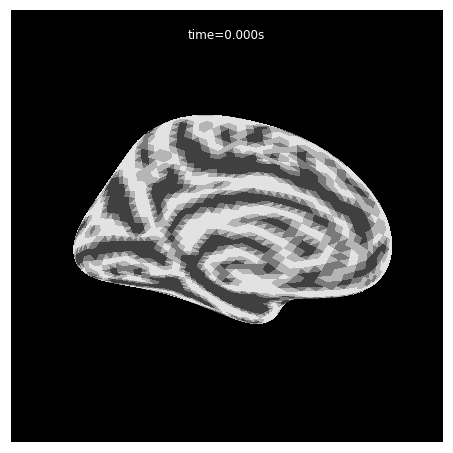

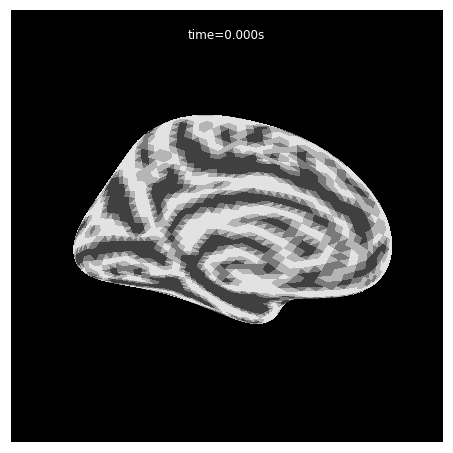

In [20]:
stat_stc.plot(colormap='magma')

In [3]:
names = ['T_ECG_included', 'T_ECG_excluded']#'R_ECG_included', 'R_ECG_excluded', 
name = names[0]
noise_cov = 'empty_room_cov'
sfreq = 200
win = (-.175,-.075)#(.1,.2)
surface = 'ico4'

stc = dict()
for i,w in enumerate([(-.175,-.075),(.1,.2)]):
    data_file = op.join(Analysis_path, task, 'meg', 'SourceEstimate', 'fsaverage', 'DATASET-{}-surface_{}-{}_{}-{}Hz.nc'.format(noise_cov, surface, *w, sfreq))
    stc[i] = xr.open_dataarray(data_file, name)
    stc[i].load()

In [4]:
T_obs=dict(); clusters=dict(); cluster_pv=dict(); H0=dict(); clu=dict()
vertno = np.arange(stc[0].shape[-1]/2, dtype=int)

stat_path = op.join(Analysis_path, task, 'meg', 'Stats', 'baseline')
os.makedirs(stat_path, exist_ok=True)
stat_file = op.join(stat_path, '{}-{}-surface_{}-{}Hz-baseline.nc'.format(name, noise_cov, surface, sfreq))

In [ ]:
test_key = 'RS'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc[1].loc['RS'].values, stc[0].loc['RS'].values, stat_file=stat_file, test_key=test_key, times=stc[0].time, vertices=vertno, connectivity=connectivity, paired=True)
test_key = 'FA'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc[1].loc['FA'].values, stc[0].loc['FA'].values, stat_file=stat_file, test_key=test_key, times=stc[0].time, vertices=vertno, connectivity=connectivity, paired=True)
test_key = 'OM'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test(stc[1].loc['OM'].values, stc[0].loc['OM'].values, stat_file=stat_file, test_key=test_key, times=stc[0].time, vertices=vertno, connectivity=connectivity, paired=True)


In [5]:
def cluster_perm_test1(X1, X2, stat_file, test_key, times=None, vertices=None, mode='a', connectivity='ico5', paired=False):
    """
    If paired, test X1-X2.
    Input: arrays of shape (subjects, time, space)
    """
    if not isinstance(X2, (np.ndarray, xr.DataArray)):
        X2 = np.zeros(X1.shape)
    
    if type(connectivity) is str:
        connectivity = mne.spatial_tris_connectivity(mne.grade_to_tris(int(connectivity[-1])))
    
    if paired:
        X = X1 - X2
        T_obs, clusters, cluster_pv, H0 = permutation_cluster_1samp_test(X, connectivity=connectivity, n_jobs=4)
    else:
        T_obs, clusters, cluster_pv, H0 = permutation_cluster_test([X1,X2], connectivity=connectivity, n_jobs=4)
    
    p_val = np.ones(T_obs.shape)
    clu_inds = np.zeros(T_obs.shape)
    
    for c,clu in enumerate(clusters):
        p_val[clu] = cluster_pv[c]
        clu_inds[clu] = c+1
    
    if times is not None:
        stats = np.zeros((3, *T_obs.shape))
        stats = xr.DataArray(stats, dims=['data', 'hemisphere', 'time'], coords={'data':['T_stat', 'p_val', 'clu_inds'], 'hemisphere':['left', 'right'], 'time':times})
        stats.loc['T_stat'] = T_obs
        stats.loc['p_val'] = p_val
        stats.loc['clu_inds'] = clu_inds
    
    if vertices is not None:
        stats = np.zeros((3, 2, len(vertices)))
        stats = xr.DataArray(stats, dims=['data', 'hemisphere', 'src'], coords={'data':['T_stat', 'p_val', 'clu_inds'], 'hemisphere':['left', 'right'], 'src':vertices})
        for h,hemi in enumerate(['left', 'right']):
            i = h + 1
            h *= len(vertices)
            i *= len(vertices)
            stats.loc['T_stat', hemi] = T_obs[h:i]
            stats.loc['p_val', hemi] = p_val[h:i]
            stats.loc['clu_inds', hemi] = clu_inds[h:i]
    
    os.makedirs(op.split(stat_file)[0], exist_ok=True)
    if not op.isfile(stat_file):
        mode = 'w'
    
    stats.to_netcdf(path=stat_file, group=test_key, mode=mode)
    
    return T_obs, clusters, cluster_pv, H0

In [8]:
test_key = 'RS_t_avg'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test1(stc[1].loc['RS'].mean(dim='time').values, stc[0].loc['RS'].mean(dim='time').values, stat_file=stat_file, test_key=test_key, vertices=vertno, connectivity=connectivity, paired=True)
test_key = 'FA_t_avg'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test1(stc[1].loc['FA'].mean(dim='time').values, stc[0].loc['FA'].mean(dim='time').values, stat_file=stat_file, test_key=test_key, vertices=vertno, connectivity=connectivity, paired=True)
test_key = 'OM_t_avg'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = cluster_perm_test1(stc[1].loc['OM'].mean(dim='time').values, stc[0].loc['OM'].mean(dim='time').values, stat_file=stat_file, test_key=test_key, vertices=vertno, connectivity=connectivity, paired=True)


Using a threshold of 2.034515
stat_fun(H1): min=-3.472786 max=3.569783
Running initial clustering
Found 81 clusters
Permuting 1023 times...


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.0min finished


Computing cluster p-values
Done.
Using a threshold of 2.034515
stat_fun(H1): min=-4.245138 max=2.861377
Running initial clustering
Found 66 clusters
Permuting 1023 times...


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.2min remaining:  2.2min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.3min finished


Computing cluster p-values
Done.
Using a threshold of 2.034515
stat_fun(H1): min=-3.930486 max=3.650433
Running initial clustering
Found 71 clusters
Permuting 1023 times...


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.1min finished


Computing cluster p-values
Done.


In [ ]:
test_key = 'RS_avg'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = mne.stats.permutation_cluster_1samp_test(stc[1].loc['RS'].mean(dim='time').values - stc[0].loc['RS'].mean(dim='time').values, connectivity=connectivity, n_jobs=4)
test_key = 'FA_avg'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = mne.stats.permutation_cluster_1samp_test(stc[1].loc['FA'].mean(dim='time').values - stc[0].loc['FA'].mean(dim='time').values, connectivity=connectivity, n_jobs=4)
test_key = 'OM_avg'
T_obs[test_key], clusters[test_key], cluster_pv[test_key], H0[test_key] = clu[test_key] = mne.stats.permutation_cluster_1samp_test(stc[1].loc['OM'].mean(dim='time').values - stc[0].loc['OM'].mean(dim='time').values, connectivity=connectivity, n_jobs=4)


In [15]:
stc[0].loc['RS'].mean(dim='time')

<xarray.DataArray (subject: 34, time: 20, src: 20484)>
array([[[ 2.008773,  2.415848, ...,  3.622698,  3.64611 ],
        [ 2.621764,  1.310435, ...,  1.530294,  1.259914],
        ...,
        [ 3.962548,  1.117905, ...,  1.488668,  1.574307],
        [ 4.025879,  1.885759, ...,  1.656659,  1.290358]],

       [[ 4.133355,  0.232459, ...,  1.052002,  0.278649],
        [ 2.540437,  0.676301, ...,  1.966223,  2.014599],
        ...,
        [ 1.747391,  1.61533 , ...,  0.507072,  0.705719],
        [ 1.883386,  1.496186, ...,  1.206225,  1.12366 ]],

       ...,

       [[10.341312,  1.209733, ..., 10.001292, 13.398304],
        [ 5.835235,  2.712691, ...,  9.20078 , 11.161971],
        ...,
        [ 3.612529,  0.464087, ...,  5.773848,  5.331923],
        [ 4.28245 ,  0.745975, ...,  5.716484,  5.330768]],

       [[ 1.972293,  3.949046, ...,  2.781159,  2.492463],
        [ 2.52077 ,  4.748508, ...,  3.543824,  3.394486],
        ...,
        [ 4.166091,  0.753249, ...,  1.060799,  

In [10]:
stop

0.245